In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
%matplotlib notebook

In [2]:
# Select CPU/GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


In [3]:
# Generate a fake data set
targets = [np.asarray([mean, stdev]) for mean in np.linspace(0, 1, 100) for stdev in np.linspace(0.1, 1, 100)]
images = [np.random.normal(mean, stdev, size=(100, 100, 1)) for mean, stdev in targets]

In [4]:
# Swap the axes so that the components come first
images = [np.swapaxes(image, 0, 2) for image in images]

In [5]:
class MyDataset(Dataset):

    def __init__(self, X, Y):
        super().__init__()
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.Y[idx])

    def __len__(self):
        return len(self.X)


# Split the data into train, validation, test
X_trv,   X_test, Y_trv,   Y_test = train_test_split(images, targets, train_size=0.8)
X_train, X_val,  Y_train, Y_val  = train_test_split(images, targets, train_size=0.75)

# Convert to Pytorch data loaders
batch_size = 100
training   = DataLoader(MyDataset(X_train, Y_train), batch_size=batch_size)
validation = DataLoader(MyDataset(X_val,   Y_val),   batch_size=batch_size)
test       = DataLoader(MyDataset(X_test,  Y_test),  batch_size=batch_size)

In [10]:
# Define our CNN
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(100*100*2, 2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.sig(self.fc(out))
        return out

Early stopping at epoch 36 out of 50 total.


<IPython.core.display.Javascript object>


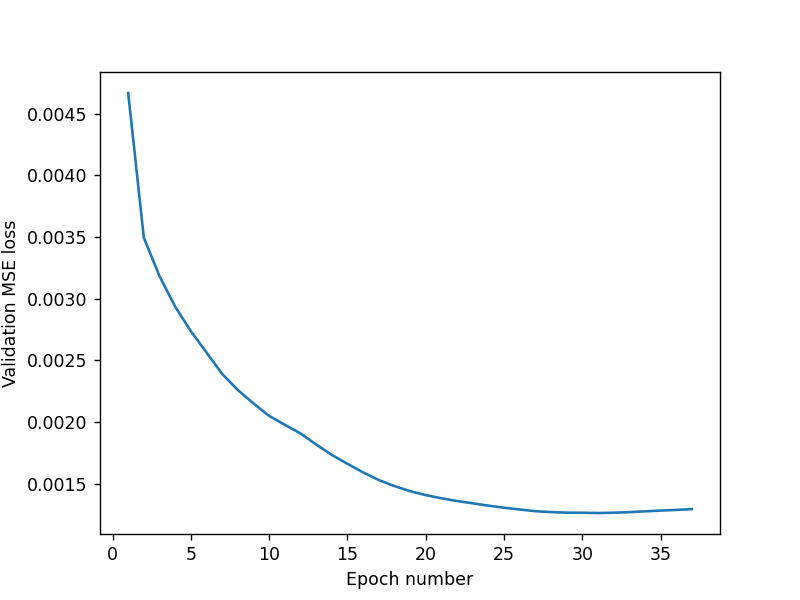

Text(0, 0.5, 'Validation MSE loss')

In [13]:
# Training parameters
num_epochs = 50
learning_rate = 0.0001

# Model, loss, and optimizer
cnn = CNN()
cnn = cnn.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the model
validation_losses = []
for epoch in tqdm(range(num_epochs), desc='Epochs', leave=False):

    # Training loss
    cnn.train()
    for i, (images, targets) in enumerate(tqdm(training, desc='Train batches', leave=False)):

        images, targets = images.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        outputs = cnn(images)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    cnn.eval()
    epoch_losses = []
    for i, (images, targets) in enumerate(tqdm(validation, desc='Validation batches', leave=False)):

        images, targets = images.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        outputs = cnn(images)
        loss_val = criterion(outputs, targets).item()
        epoch_losses.append(loss_val)

    # Early stopping
    patience = 7
    validation_losses.append(np.mean(epoch_losses))
    if len(validation_losses) >= patience and np.argmin(validation_losses[-patience:]) == 0:
        print(f"Early stopping at epoch {epoch} out of {num_epochs} total.")
        break

else:
    print(f"No early stopping used. Completed {num_epochs} epochs.")

# Plot the training curve
plt.plot(np.arange(len(validation_losses)) + 1, validation_losses)
plt.xlabel('Epoch number')
plt.ylabel('Validation MSE loss');

## Animal images

In [ ]:
from glob import glob

from PIL import Image

In [ ]:
# Standardize the image inputs
def sanitize(img):
    """
    Convert a jpeg into an 100x100, 2 component image.
    """
    # Resize image
    min_length = min(img.size)
    img = img.crop((0, 0, min_length, min_length))
    img = img.resize((100, 100))

    # Convert to 2-channel pixel array
    return np.asarray([[r, 255-g] for r, g, b in img.getdata()]).reshape(100, 100, 2)

In [ ]:
# Assemble images
labels = ['giraffe', 'leopard', 'zebra']
images = {label: [sanitize(Image.open(image)) for image in glob(f"patterns/{label}_*.jpg")] for label in labels}

In [ ]:
# Demonstrate 2-component image
img = images['zebra'][0]
plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gist_gray')
plt.subplot(122)
plt.imshow(img[:,:,1], cmap='gist_gray')